In [1]:
import sys
sys.path.append("./../../src")
from visualizer_helper import Visualizer
from cluster_helper import ClusterProcessor

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing
from scipy.sparse import csr_matrix
import scipy
import pickle
import os
from annoy import AnnoyIndex
from scipy.sparse.linalg import inv

from collections import Counter
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrew/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
k_neighbors = 50
knn_clusters = 50
keep_k_evecs = 10
drop_k_evecs=2

cluster_assignments = pd.read_csv("./data/CLUSTER_ASSIGNMENTS.csv")
icd9codes = pd.read_csv("../../data/PATIENT_ICD_ICD9_CODES.csv")
patient_icd_binary = pickle.load(open("../../data/PATIENT_ICD_BINARY_SPARSE_CSR.p", 'rb'))
icd9diag = pd.read_csv("../../../mimic/D_ICD_DIAGNOSES.csv.gz")
icd9proc = pd.read_csv("../../../mimic/D_ICD_PROCEDURES.csv.gz")

A = pickle.load(open("./data/A_mknn_K{}_CSR.p".format(k_neighbors), "rb"))

Y_cluster_labels = pickle.load(open("./data/cluster_labels_K{}_knn{}_topkevecs{}_drop{}.p".format(k_neighbors, knn_clusters, keep_k_evecs, drop_k_evecs), 'rb'))
Y_mc_cluster_labels = pickle.load(open("./data/cluster_labels_mc_K{}_knn{}_topkevecs{}_drop{}.p".format(k_neighbors, knn_clusters, keep_k_evecs, drop_k_evecs), 'rb'))

In [3]:
cp = ClusterProcessor(patient_icd_binary, icd9codes, icd9diag, cluster_assignments, k_neighbors,
                        other_stopwords = ["hypertension", 'disorder'])

In [4]:
cp.top_diseases_in_cluster(cluster=14, topk=10)

,ICD9_CODE,SHORT_TITLE,DISEASE_COUNT
0,51881,Acute respiratry failure,590
1,2762,Acidosis,325
2,5070,Food/vomit pneumonitis,296
3,311,Depressive disorder NEC,170
4,2859,Anemia NOS,159
5,3051,Tobacco use disorder,154
6,5849,Acute kidney failure NOS,149
7,9654,Pois-arom analgesics NEC,130
8,5990,Urin tract infection NOS,127
9,E9503,Poison-psychotropic agt,125


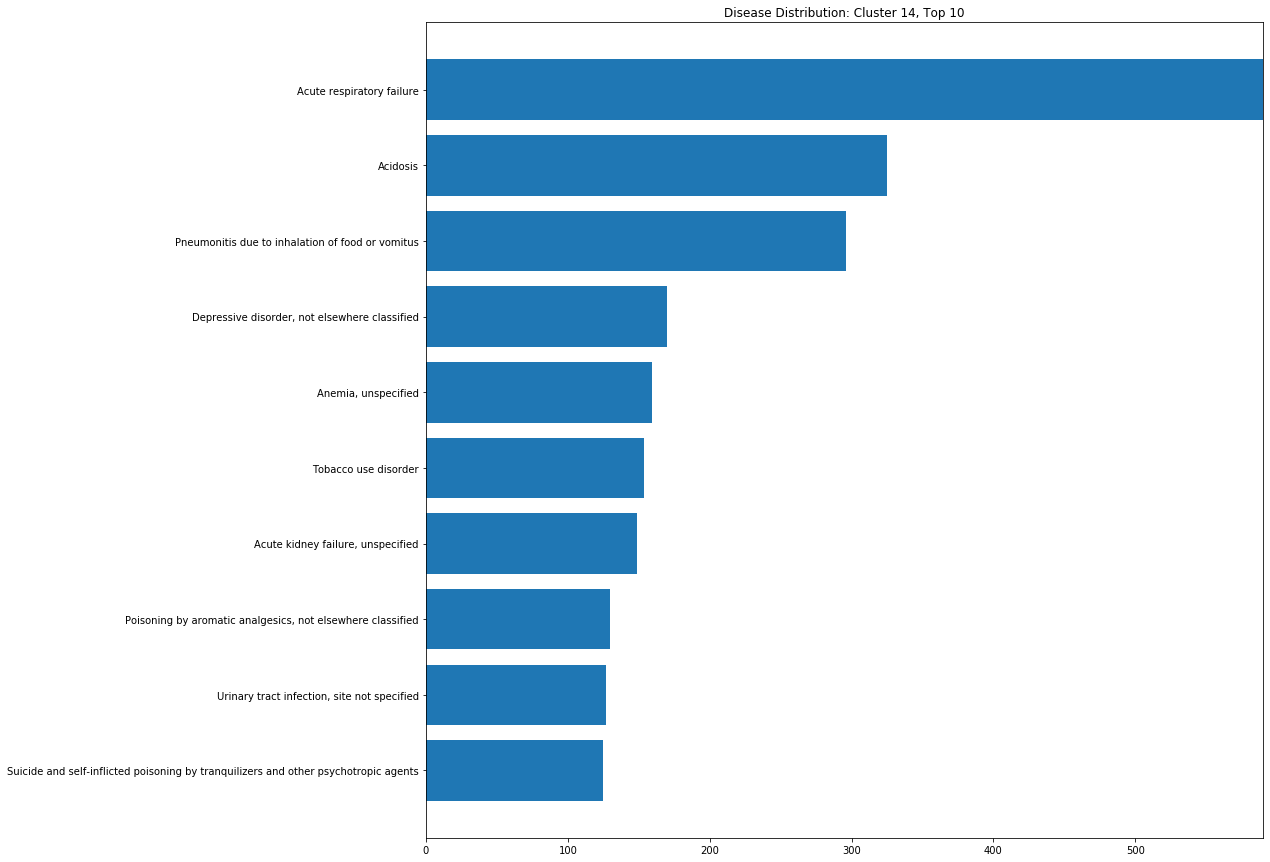

[('51881', 'Acute respiratory failure', 590),
 ('2762', 'Acidosis', 325),
 ('5070', 'Pneumonitis due to inhalation of food or vomitus', 296),
 ('311', 'Depressive disorder, not elsewhere classified', 170),
 ('2859', 'Anemia, unspecified', 159),
 ('3051', 'Tobacco use disorder', 154),
 ('5849', 'Acute kidney failure, unspecified', 149),
 ('9654', 'Poisoning by aromatic analgesics, not elsewhere classified', 130),
 ('5990', 'Urinary tract infection, site not specified', 127),
 ('E9503',
  'Suicide and self-inflicted poisoning by tranquilizers and other psychotropic agents',
  125)]

In [5]:
cp.plot_disease_distribution(10, cluster=14)

In [6]:
A_sorted = cp.sort_by_cluster_membership(A, mc_cluster=False)
A_mc_sorted = cp.sort_by_cluster_membership(A, mc_cluster=True)
pickle.dump(A_sorted, open("./data/A_sorted_K{}.p".format(k_neighbors),"wb"))
pickle.dump(A_mc_sorted, open("./data/A_mc_sorted_K{}.p".format(k_neighbors),"wb"))

In [16]:
A_sorted_copy = A_sorted.copy()
A_sorted_copy.eliminate_zeros()

In [17]:
print(np.min(A_sorted), np.max(A_sorted), A_sorted_copy.mean())

0.0 7.38905609893065 0.000555116210455573


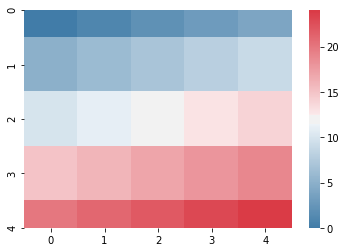

In [23]:
x = np.arange(25).reshape(5, 5)
cmap = sns.diverging_palette(240, 10, as_cmap=True)
ax = sns.heatmap(x, cmap=cmap)

In [5]:
K = cp.build_cluster_matrix(mc_cluster=False)
K_mc = cp.build_cluster_matrix(mc_cluster=True)
pickle.dump(K, open("./data/K_K{}_knn{}.p".format(k_neighbors, knn_clusters), "wb"))
pickle.dump(K_mc, open("./data/K_mc_K{}_knn{}.p".format(k_neighbors, knn_clusters), "wb"))

In [6]:
KA = K.T.dot(A_sorted)
KA_mc = K_mc.T.dot(A_mc_sorted)

KAK = K.T.dot(A_sorted).dot(K)
KAK_mc = K_mc.T.dot(A_mc_sorted).dot(K_mc)

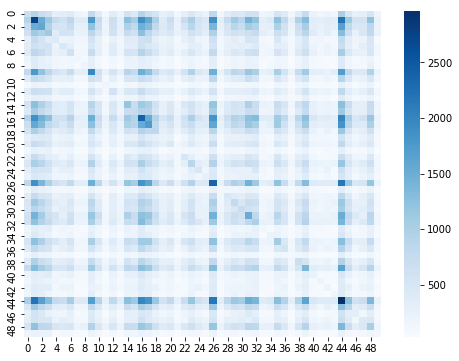

In [7]:
plt.figure(figsize=(8,6))
sns.heatmap(KAK.toarray(), cmap="Blues")

In [27]:
lc=100

Y_umap_2d = pickle.load(open("./data/Y_umap_2d_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'rb'))
Y_umap_3d = pickle.load(open("./data/Y_umap_3d_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'rb'))

Y_mc_umap_2d = pickle.load(open("./data/Y_umap_2d_mc_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'rb'))
Y_mc_umap_3d = pickle.load(open("./data/Y_umap_3d_mc_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'rb'))

Y_c_umap_2d = cp.compute_centroids(Y_umap_2d, mc_cluster=False)
Y_c_umap_3d = cp.compute_centroids(Y_umap_3d, mc_cluster=False)
Y_mc_c_umap_2d = cp.compute_centroids(Y_mc_umap_2d, mc_cluster=True)
Y_mc_c_umap_3d = cp.compute_centroids(Y_mc_umap_3d, mc_cluster=True)

100%|██████████| 50/50 [00:00<00:00, 6709.60it/s]


 26%|██▌       | 13/50 [00:00<00:00, 121.38it/s]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


100%|██████████| 50/50 [00:00<00:00, 5649.50it/s]


Done


100%|██████████| 50/50 [00:00<00:00, 2914.09it/s]

Done


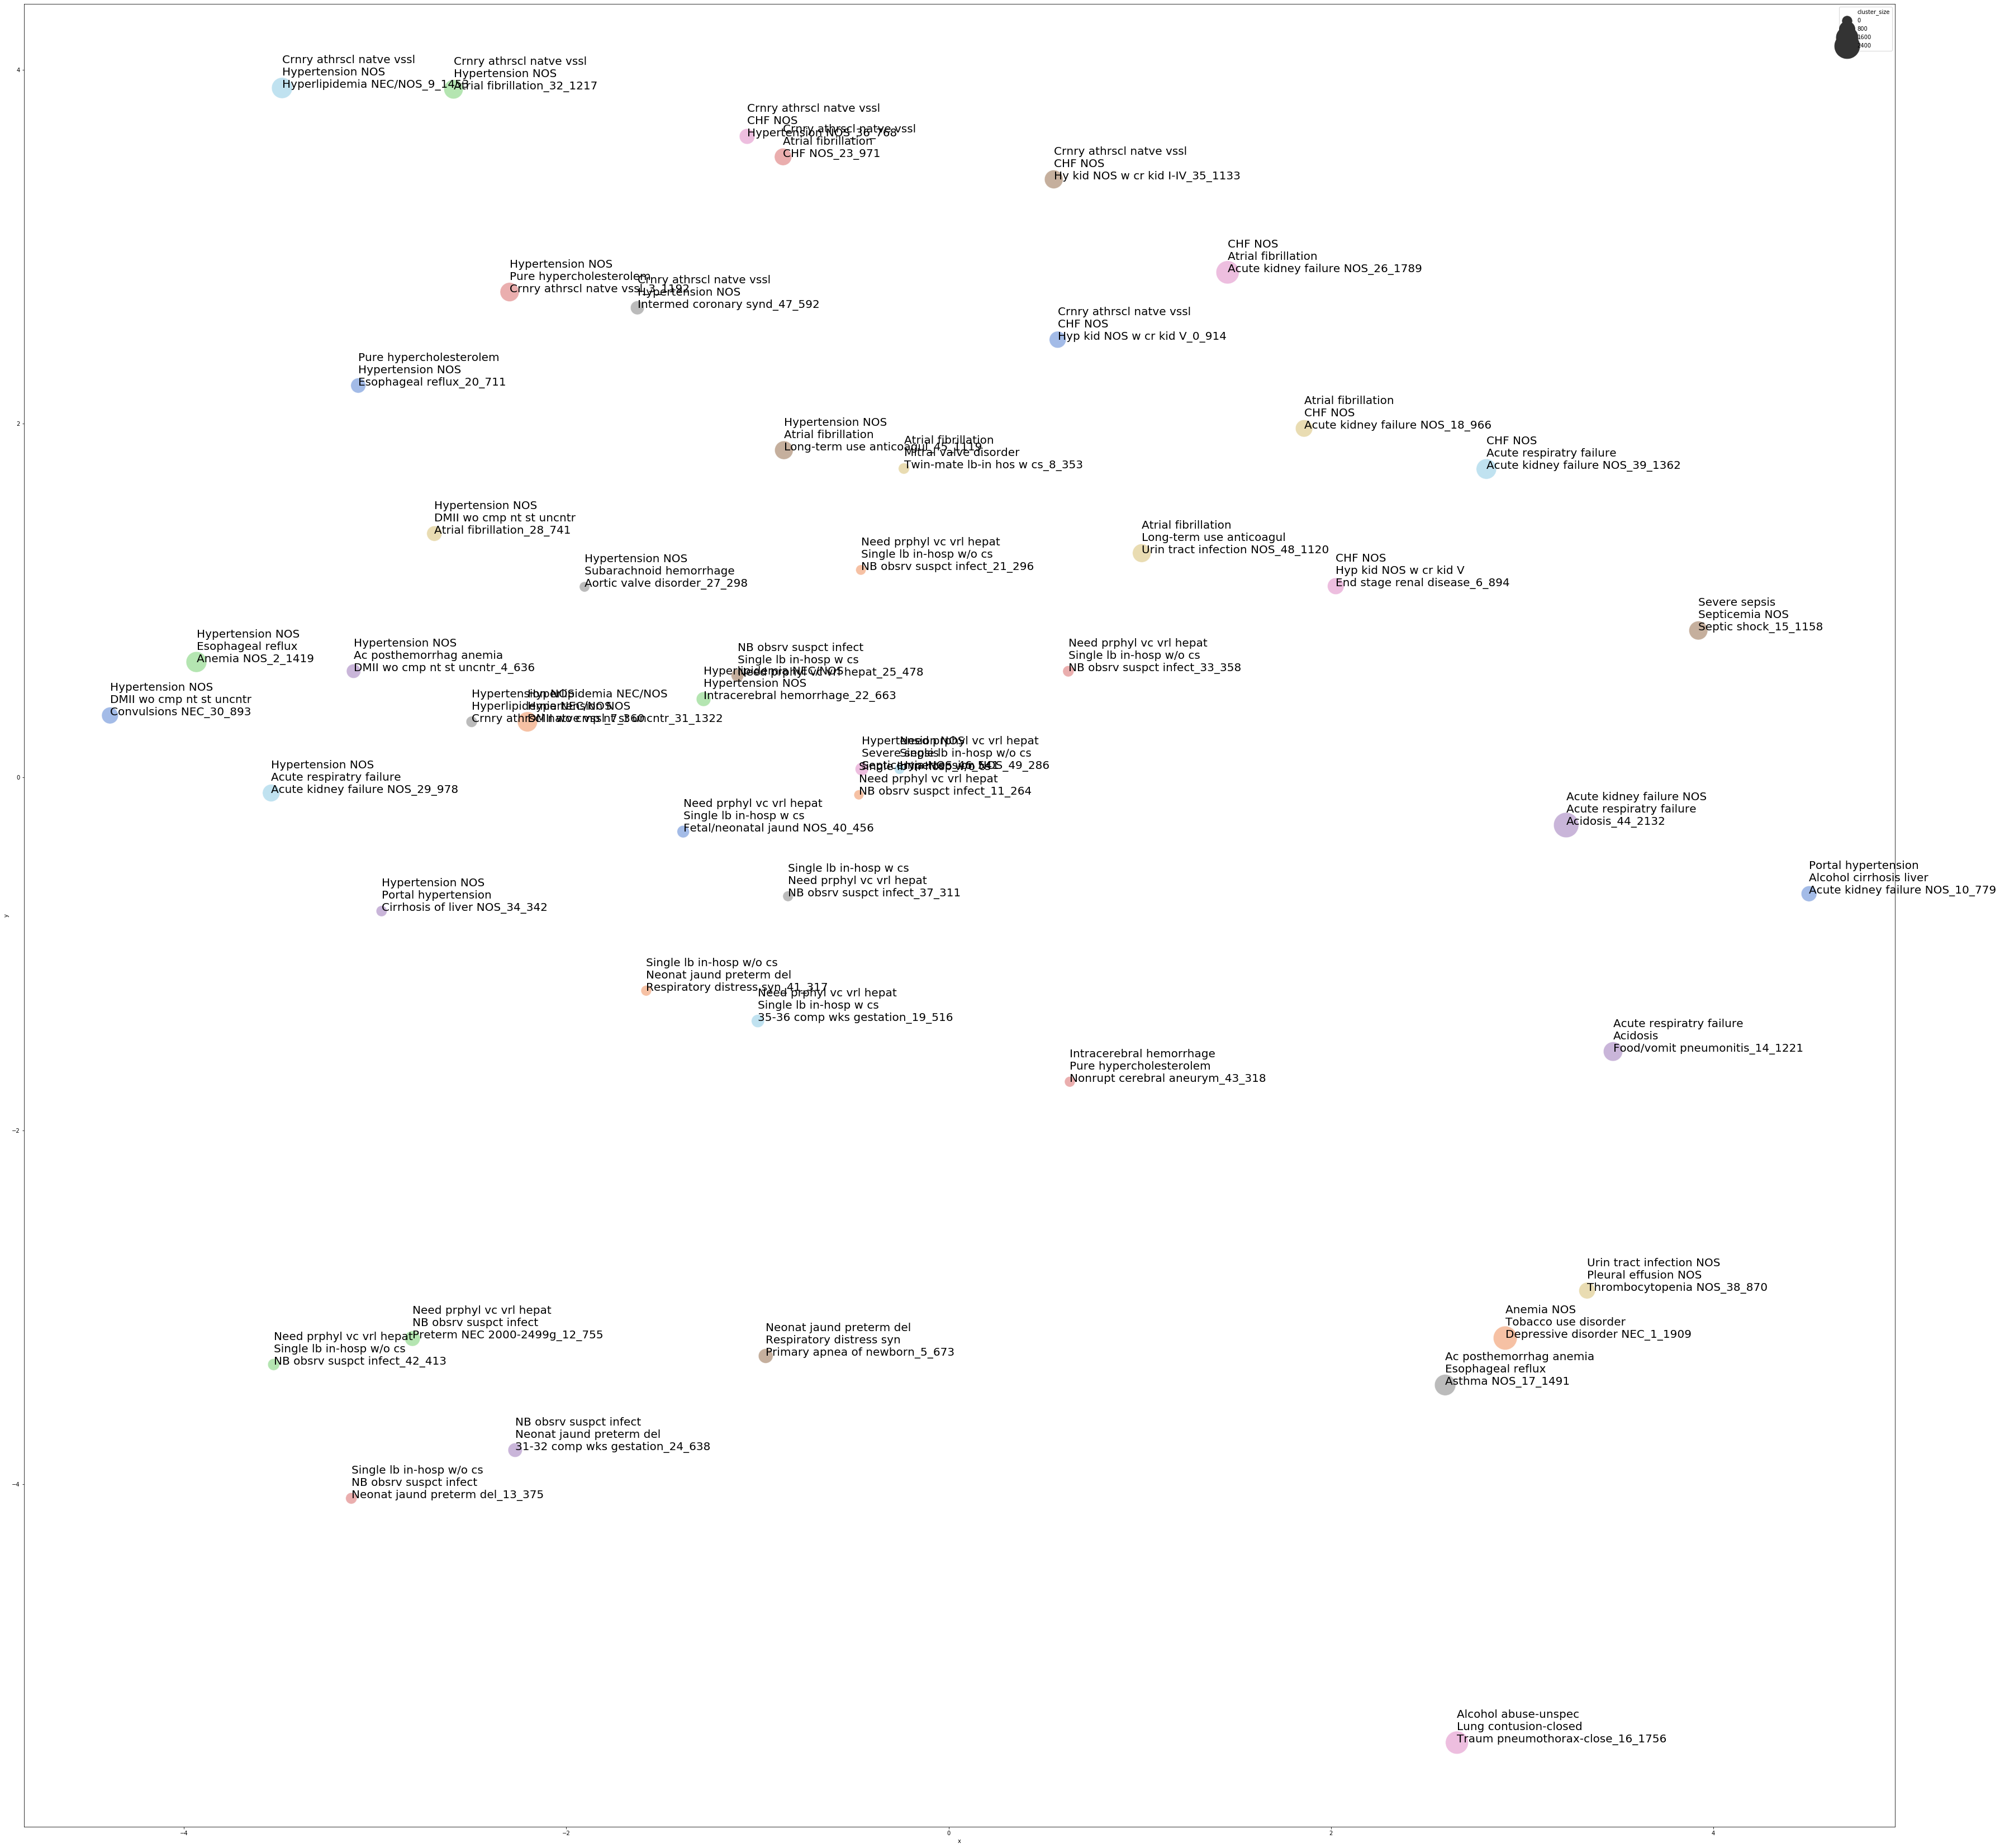

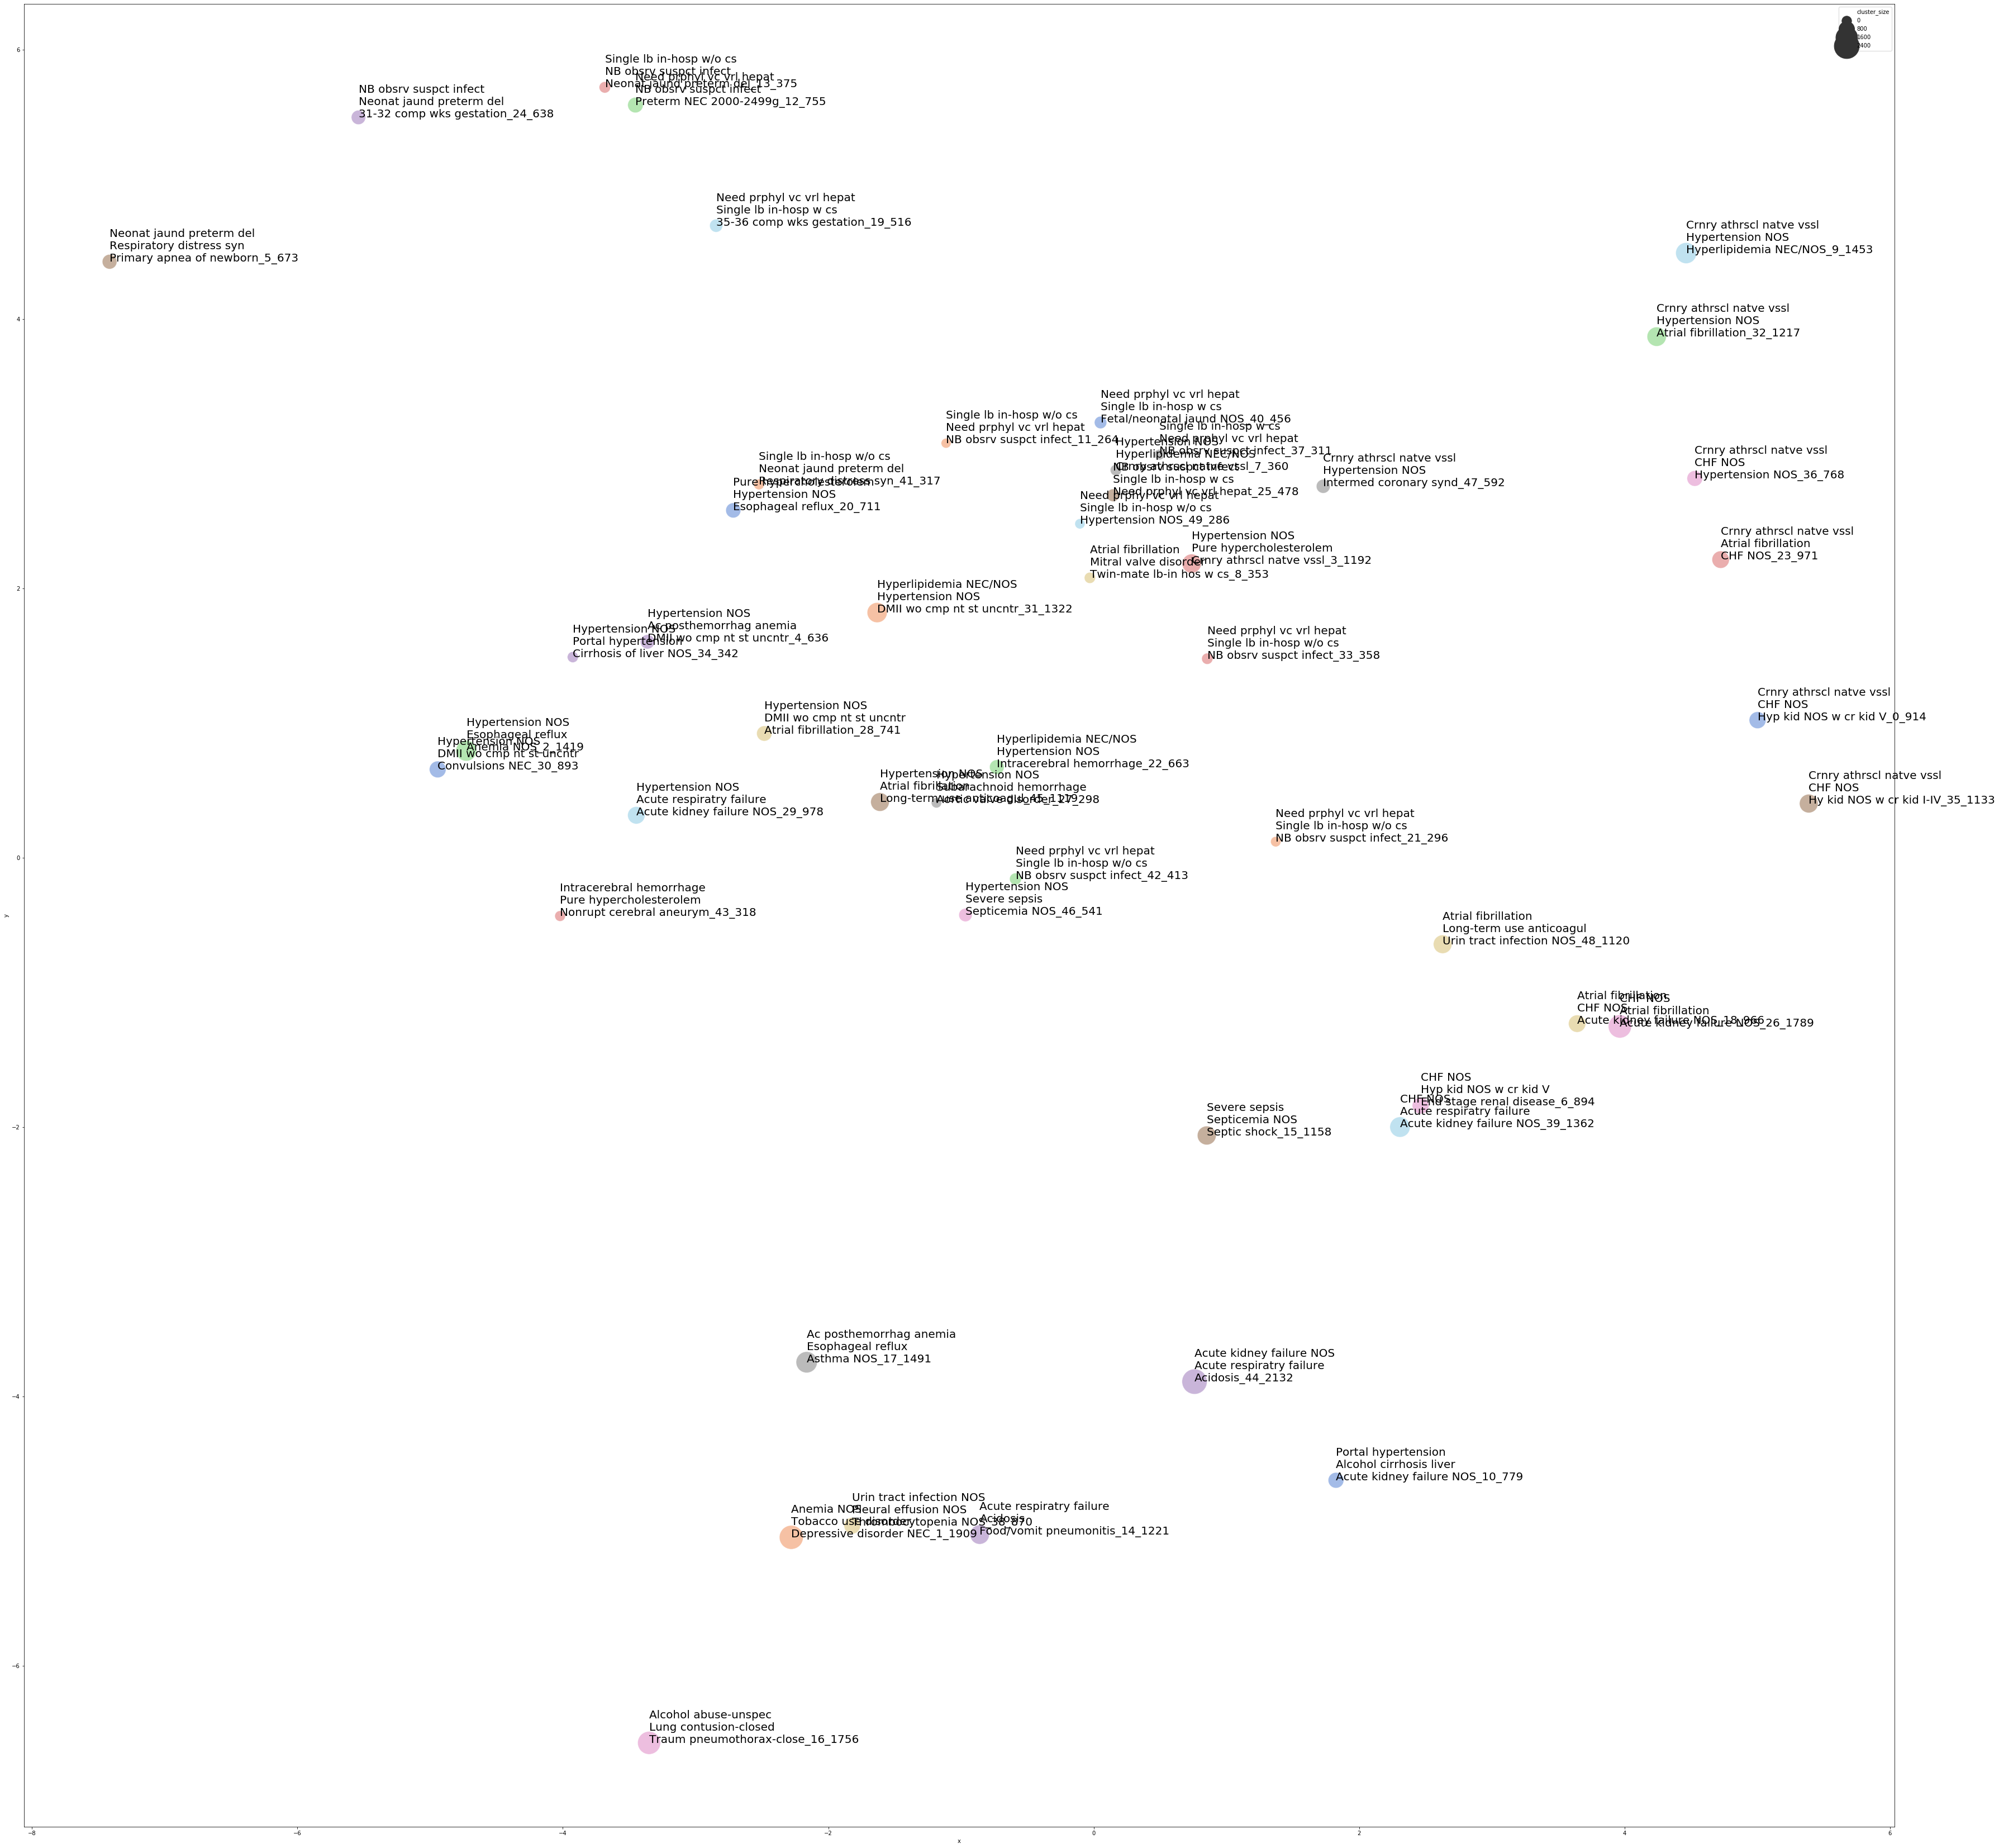

In [32]:
def create_centroid_cluster_df(y, cluster_labels, topk=3):
    centroids = cp.compute_centroids(y, mc_cluster=False)
    
    x = centroids[:, 0].tolist()
    y = centroids[:, 1].tolist()
    cluster_sizes = np.unique(cluster_labels, return_counts=True)[1].tolist()
        
    titles = ["" for _ in range(centroids.shape[0])]
    # print(len(titles))
    for c in tqdm(np.unique(cluster_labels)):
        top_k_df = cp.top_diseases_in_cluster(cluster=c, topk=3, short_title=True)
        # print(top_k_df)
        top_k_titles = top_k_df["SHORT_TITLE"].values.tolist()
        # print(top_k_titles)
        top_k_titles_asstr = "\n".join(top_k_titles)
        # print(top_k_titles_asstr)
        titles[c] = top_k_titles_asstr
        # break
        
        
    centroid_dict = {"x": x,
                     "y": y,
                     "cluster_size": cluster_sizes,
                     "cluster": np.unique(cluster_labels).tolist(),
                     "title": titles
                    }
    
    if centroids.shape[-1] == 3:
        z = centroids[:, 2].tolist()
        centroid_dict['z'] = z
        
    return pd.DataFrame(centroid_dict)

print(np.unique(Y_cluster_labels))


Y_2d_df = create_centroid_cluster_df(Y_umap_2d, Y_cluster_labels)
print("Done")
plt.figure(figsize=(60,60))
ax = sns.scatterplot(x="x", y="y", size="cluster_size", hue="cluster",
            sizes=(300, 2000), alpha=.5, palette="muted",
            data=Y_2d_df)
for line in tqdm(range(0,Y_2d_df.shape[0])):
     ax.text(Y_2d_df.x[line], Y_2d_df.y[line], Y_2d_df.title[line] + "_" + str(Y_2d_df.cluster[line]) + "_" + str(Y_2d_df.cluster_size[line]), size=20)

h,l = ax.get_legend_handles_labels()
plt.legend(h[-5:], l[-5:], loc="upper right")

# plt.savefig("./figures/y_umap_centroid_clusters.png")

Y_2d_df = create_centroid_cluster_df(Y_mc_umap_2d, Y_cluster_labels)
print("Done")
plt.figure(figsize=(60,60))
ax = sns.scatterplot(x="x", y="y", size="cluster_size", hue="cluster",
            sizes=(300, 2000), alpha=.5, palette="muted",
            data=Y_2d_df)
for line in tqdm(range(0,Y_2d_df.shape[0])):
#     ax.text(Y_2d_df.x[line], Y_2d_df.y[line], Y_2d_df.title[line], size=20)
    ax.text(Y_2d_df.x[line], Y_2d_df.y[line], Y_2d_df.title[line] + "_" + str(Y_2d_df.cluster[line]) + "_" + str(Y_2d_df.cluster_size[line]), size=20)




h,l = ax.get_legend_handles_labels()
plt.legend(h[-5:], l[-5:], loc="upper right")

# plt.savefig("./figures/y_mc_umap_centroid_clusters.png")

In [23]:
evecs = 50
L_evecs = pickle.load(open("./data/L_evecs{}_K{}.p".format(evecs, k_neighbors), 'rb'))
L_mc_evecs = pickle.load(open("./data/L_mc_evecs{}_K{}.p".format(evecs, k_neighbors), "rb"))